# Plotting of data HD blastwave

In [1]:
import script.pyPLUTO as pp
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd

# some commonly used constants
CONST_mp = 1.67262171e-24  # gr

Increase rsolution of plots

In [9]:
mpl.rcParams["figure.dpi"] = 150    # about the dpi for a 15 inch 1080p laptop, makes sure the displayed plots are the real size 
#mpl.rcParams["figure.dpi"] = 600

mpl.rcParams["figure.figsize"] = (6, 3.5)
mpl.rcParams["axes.labelsize"] = 20

mpl.rcParams["axes.formatter.limits"] = (-4, 4)

mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=["xkcd:royal blue", "xkcd:vermillion", "xkcd:lime",
                                  "xkcd:yellow", "xkcd:orange", "xkcd:magenta", "grey"])

mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["axes.linewidth"] = .5

mpl.rcParams["font.size"] = 12

mpl.rcParams["text.usetex"] = True


#mpl.rcParams["figure.facecolor"] = "#fffbf0"
#mpl.rcParams["axes.facecolor"] = "#fffbf0"
#mpl.rcParams["savefig.facecolor"] = '#fffbf0'

Usefull functions

In [3]:
def get_extent(file, firstline):
    """this functions retrieves the extent of the grid (in code-units) and number of points from the grid.out 
    file in one dimension (starting at firstline)
    
    file: the grid.out file
    firstline: the line in the file to look for the number of points in that dimension"""
    with open(file, "r") as gridfile:
        lines = gridfile.readlines()
        # get the number of points
        NUM_POINTS = int(lines[firstline])

        # get the extent of the x-axis (in code units)
        # the first line of the grid, so minimum coordinate
        line = lines[firstline+1]
        parts = line.split()
        # remove the spaces
        for part in parts:
            if part == " ":
                del part
        d_min = float(parts[1])
        # the last line
        line = lines[firstline+NUM_POINTS]
        parts = line.split()
        # remove the spaces
        for part in parts:
            if part == " ":
                del part
        d_max = float(parts[2])
    
    return (NUM_POINTS, (d_min, d_max))

## get metadata of the simulation data

In [4]:
# specify the directories where the data is stored and where the output should be stored
DATA_DIR = "data/25d-low-pressure/"
OUT_DIR = "images/"

# define the conversion factors, can be seen when starting the simulation
UNIT_DENSITY = 1e9*CONST_mp
UNIT_LENGTH = 1e8 # cm (1AU)
UNIT_VELOCITY = 1e8 # cm/s
UNIT_TIME = UNIT_LENGTH/UNIT_VELOCITY
UNIT_PRESSURE = 1.673e1   # dyne/cm^2

In [5]:
# get info about the stored data
file_data = pd.read_csv(DATA_DIR+"dbl.out", sep=" ", names=["index", "t", "dt", "step", "type", "little", "rho",
                                                            "vx1", "vx2", "vx3", "Bx1", "Bx2", "Bx3", "prs", "psi_glm", "empty"])
# delete columns that are not needed
for column in ["index", "type", "little", "rho", "vx1", "vx2", "vx3", "Bx1", "Bx2", "Bx3", "prs", "psi_glm", "empty"]:
    del file_data[column]

X_POINTS = 0
Y_POINTS = 0
X_EXTENT = (0,0)
Y_EXTENT = (0,0)

# get the extend of the grid
# get the extent of the x-axis (in code units)
X_POINTS, X_EXTENT = get_extent(DATA_DIR+"grid.out", 9)
# get the extent of the y-axis
Y_POINTS, Y_EXTENT = get_extent(DATA_DIR+"grid.out", 10+X_POINTS)

# number of files saved
N = len(file_data["t"])

# physical extent of the grid
extent_temp = X_EXTENT + Y_EXTENT
extent = [value*UNIT_LENGTH for value in extent_temp]
# physical time data
T = file_data["t"].values*UNIT_TIME

## Plots for report

### fig, ax = plt.subplots(2,3, figsize=(6.5,4))

ex = [x*1e-8 for x in extent]

indicies = [0,5,10]
DIRS = ["data/25d-high-pressure/", "data/25d-low-pressure/"]
DATA = [pp.pload(indicies[i%3], w_dir=DIRS[i//3]) for i in range(6)]
plotvars = [data.prs for data in DATA]
UNIT = UNIT_PRESSURE
mins = [1,1]
maxs = [1,1]
for i in range(3):
    if (m := np.min(plotvars[i])) < mins[0]:
        mins[0] = m
    if (M := np.max(plotvars[i])) > maxs[0]:
        maxs[0] = M
        
for i in range(3,6):
    if (m := np.min(plotvars[i])) < mins[1]:
        mins[1] = m
    if (M := np.max(plotvars[i])) > maxs[1]:
        maxs[1] = M

for i in range(6):
    axis = ax[i//3][i%3]
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)
    if i//3 == 0:
        axis.set_title("t=%.1e s" %(T[indicies[i%3]]), pad=12)
    
    im=axis.imshow(plotvars[i]*UNIT, cmap="viridis", extent=ex,
                  vmin=mins[i//3]*UNIT, vmax=maxs[i//3]*UNIT)
    if i%3 == 2:
        cbar = fig.colorbar(im, ax=axis)
        #cbar.ax.set_ylabel('pressure [$g/cm^3$]', rotation=270, labelpad=15.0)

        
for column in range(3):
    ax[1][column].get_xaxis().set_visible(True)
    #ax[1][column].set_xlabel(r"distance $[cm]$", labelpad=12.0)
for row in range(2):
    ax[row][0].get_yaxis().set_visible(True)
    #ax[row][0].set_ylabel(r"distance $[cm]$")
    
fig.text(0.5, 0.03, r"distance $[10^8cm]$", va='center')
fig.text(0.03, 0.5, r"distance $[10^8cm]$", va='center', rotation=90)
fig.text(0.97, 0.5, r"pressure $[dyne/cm^2]$", va="center", rotation=270)

fig.suptitle("Pressure hydrodynamic blastwave", y=1)

plt.tight_layout()
plt.show()

fig.savefig("../verslag/images/HD-blast-prs-1.pdf")

Reading Data file : data/25d-high-pressure/data.0020.dbl
Reading Data file : data/25d-high-pressure/data.0030.dbl
Reading Data file : data/25d-high-pressure/data.0040.dbl
Reading Data file : data/25d-low-pressure/data.0020.dbl
Reading Data file : data/25d-low-pressure/data.0030.dbl
Reading Data file : data/25d-low-pressure/data.0040.dbl


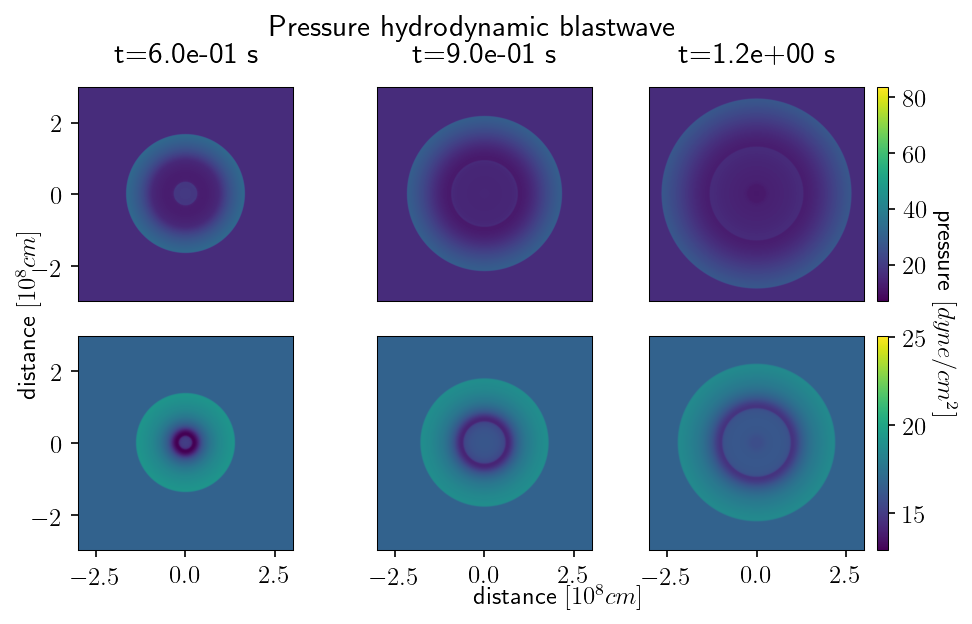

In [68]:
fig, ax = plt.subplots(2,3, figsize=(6.5,4))

indicies = [20,30,40]
DATA = [pp.pload(indicies[i%3], w_dir=DIRS[i//3]) for i in range(6)]
plotvars = [data.prs for data in DATA]
UNIT = UNIT_PRESSURE

        
for i in range(3,6):
    if (m := np.min(plotvars[i])) < mins[1]:
        mins[1] = m
    if (M := np.max(plotvars[i])) > maxs[1]:
        maxs[1] = M

for i in range(6):
    axis = ax[i//3][i%3]
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)
    if i//3 == 0:
        axis.set_title("t=%.1e s" %(T[indicies[i%3]]), pad=12)
    
    im=axis.imshow(plotvars[i]*UNIT, cmap="viridis", extent=ex,
                  vmin=mins[i//3]*UNIT, vmax=maxs[i//3]*UNIT)
    if i%3 == 2:
        cbar = fig.colorbar(im, ax=axis)
        #cbar.ax.set_ylabel('pressure [$g/cm^3$]', rotation=270, labelpad=15.0)

        
for column in range(3):
    ax[1][column].get_xaxis().set_visible(True)
    #ax[1][column].set_xlabel(r"distance $[cm]$", labelpad=12.0)
for row in range(2):
    ax[row][0].get_yaxis().set_visible(True)
    #ax[row][0].set_ylabel(r"distance $[cm]$")
    
fig.text(0.5, 0.03, r"distance $[10^8cm]$", va='center')
fig.text(0.03, 0.5, r"distance $[10^8cm]$", va='center', rotation=90)
fig.text(0.97, 0.5, r"pressure $[dyne/cm^2]$", va="center", rotation=270)

fig.suptitle("Pressure hydrodynamic blastwave", y=1)

plt.tight_layout()
plt.show()

fig.savefig("../verslag/images/HD-blast-prs-2.pdf")

## Plot the variable

In [20]:
max_prs = 1.5
min_prs = 0.9   # (larger than 0.85 cuts of echo!)
LOW = True

for j in range(N):
    D = pp.pload(j, w_dir=DATA_DIR+"/")

    fig, ax = plt.subplots(1,1)

    ##im=ax.imshow(np.log(plotvar[i]), vmin=np.log(MIN), vmax=np.log(MAX), cmap="plasma")
    ##im=ax.imshow(D.prs, cmap="plasma", extent=extent, vmin=8, vmax=16)
    im=ax.imshow(D.prs*UNIT_PRESSURE, vmin=min_prs*UNIT_PRESSURE, 
                    vmax=max_prs*UNIT_PRESSURE, cmap="plasma", extent=extent)
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('density [$g/cm^3$]', rotation=270, labelpad=15.0)

    if LOW:
        plt.title(r"low pressure difference; time: %.3e s" %(T[j]), pad=15.0)
    else:
        plt.title(r"high pressure difference; time: %.3e s" %(T[j]), pad=15.0)
    ax.set_xlabel("x-axis [cm]")
    ax.set_ylabel("y-axis [cm]")

    if LOW:
        fig.savefig(OUT_DIR+"low-prs-linear%02i.png" %(j))
    else:
        fig.savefig(OUT_DIR+"high-prs-linear%02i.png" %(j))

    plt.close(fig=fig)

Reading Data file : data/25d-low-pressure//data.0000.dbl
Reading Data file : data/25d-low-pressure//data.0001.dbl
Reading Data file : data/25d-low-pressure//data.0002.dbl
Reading Data file : data/25d-low-pressure//data.0003.dbl
Reading Data file : data/25d-low-pressure//data.0004.dbl
Reading Data file : data/25d-low-pressure//data.0005.dbl
Reading Data file : data/25d-low-pressure//data.0006.dbl
Reading Data file : data/25d-low-pressure//data.0007.dbl
Reading Data file : data/25d-low-pressure//data.0008.dbl
Reading Data file : data/25d-low-pressure//data.0009.dbl
Reading Data file : data/25d-low-pressure//data.0010.dbl
Reading Data file : data/25d-low-pressure//data.0011.dbl
Reading Data file : data/25d-low-pressure//data.0012.dbl
Reading Data file : data/25d-low-pressure//data.0013.dbl
Reading Data file : data/25d-low-pressure//data.0014.dbl
Reading Data file : data/25d-low-pressure//data.0015.dbl
Reading Data file : data/25d-low-pressure//data.0016.dbl
Reading Data file : data/25d-lo